# Reinforcement Learning - Homework 1
Ananya Gandhi, UNI: ag4348


## Programming Project

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

#### Question 1: simulate the 20 actual probabilities of click using the beta distribution $\beta (\alpha_1, \alpha_2)$ with $ \alpha_1 = 1$ and $ \alpha_2 = 7$. 

In [2]:
n = 20
a1 = 1
a2 = 7

probabilities = np.random.beta(a1, a2, n)

#### Question 2: implement the $\epsilon$-greedy method for $\epsilon \in \{0, 0.01, 0.1\}$ and a time span of $T = 1000$. Simulate performance of the $\epsilon$-greedy method 2000 times for each value of $\epsilon$ above and plot

In [3]:
class Bandit:

    def __init__(self, p_click, k_arm = 20, epsilon = 0, initial = 0, step_size = 0.1, 
                sample_averages = False, UCB_param = None, gradient = False, 
                gradient_baseline = False, true_reward = 0):
    
        self.probabilities = p_click
        self.k = k_arm
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.k)
        self.time = 0
        self.UCB_param = UCB_param
        self.gradient = gradient
        self.gradient_baseline = gradient_baseline
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon
        self.initial = initial

    def reset(self):
        self.q_true = self.probabilities
        self.q_estimation = np.zeros(self.k) + self.initial
        self.action_count = np.zeros(self.k)
        self.best_action = np.argmax(self.q_true)
        self.time = 0
    
    def act(self):
        if np.random.rand() < self.epsilon:
          return np.random.choice(self.indices)
        
        if self.UCB_param is not None:
          UCB_estimation = self.q_estimation + \
              self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count
    + 1e-5))
          q_best = np.max(UCB_estimation)
          return np.random.choice(np.where(UCB_estimation == q_best)[0])
        
        if self.gradient:
          exp_est = np.exp(self.q_estimation)
          self.action_prob = exp_est / np.sum(exp_est)
          return np.random.choice(self.indices, p=self.action_prob)
        
        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    def step(self, action):
        reward = 0
        if np.random.rand() < self.probabilities[action]:
          reward = 1
        
        self.time += 1
        self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time
        if self.sample_averages:
            # update estimation using sample averages
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        
        elif self.gradient:
            one_hot = np.zeros(self.k)
            one_hot[action] = 1
            if self.gradient_baseline:
                baseline = self.average_reward
            else:
                baseline = 0
            self.q_estimation += self.step_size * (reward - baseline) * (one_hot - self.action_prob)
        
        else:
            # update estimation with constant step size
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
        
        return reward

def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)

    for i, bandit in enumerate(bandits):
        for r in trange(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1

    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)

    return mean_best_action_counts, mean_rewards

def optimal_action(best_action_counts, bandits, epsilon=False, initial=False, ucb=False, gradient=False):

    for i in range(len(bandits)):

      if epsilon:
          plt.plot(best_action_counts[i], label='$\epsilon = $' + str(bandits[i].epsilon))
          plt.title("% Optimal Action for Varying Epsilon")

      if initial:
          plt.plot(best_action_counts[i], label='initial = ' + str(bandits[i].initial)) 
          plt.title("% Optimal Action for Varying Initial Values")
      
      if ucb:
          plt.plot(best_action_counts[i], label="c = " + str(bandits[i].UCB_param))
          plt.title("% Optimal Action for Varying UCB Parameters")

      if gradient:
          plt.plot(best_action_counts[i], label='baseline =' + str(bandits[i].gradient_baseline))
          plt.title("% Optimal Action with Alpha = " + str(bandits[i].step_size))
    
    plt.xlabel('Steps')
    plt.ylabel('% optimal action')
    plt.legend()
    plt.show()
    

def regret_figure(rewards, bandits, epsilon=False, initial=False, ucb=False, gradient=False):

    regret = np.cumsum(rewards, axis=1)
    time = len(rewards[0])

    fig, axis = plt.subplots(1,2)
    fig.set_figwidth(fig.get_figwidth() * 2)

    for t in range(time):
        for i in range(len(regret)):
            regret[i,t] = (t+1) * bandits[i].probabilities[bandits[i].best_action] - regret[i,t]
            #regret[i,t] = (time) * bandits[i].probabilities[bandits[i].best_action] - regret[i,t]

    for i in range(len(bandits)):

      if epsilon:
        axis[0].plot(regret[i], label='$\epsilon = $' + str(bandits[i].epsilon))
        axis[0].set_title("Regret for Varying Epsilon")

      if initial:
        axis[0].plot(regret[i], label='initial value = ' + str(bandits[i].initial))
        axis[0].set_title("Regret for Varying Initial Values")

      if ucb:
        axis[0].plot(regret[i], label="c = " + str(bandits[i].UCB_param))
        axis[0].set_title("Regret for Varying UCB Parameters")
    
      if gradient:
        axis[0].plot(regret[i], label='baseline =' + str(bandits[i].gradient_baseline))
        axis[0].set_title("Regret with Alpha = " + str(bandits[i].step_size))
    
    for i in range(len(regret)):
      for j in range(1, len(regret[0])):
        regret[i,j] /= (j+1)
    
    for i in range(len(bandits)):
      if epsilon:
        axis[1].plot(regret[i], label='$\epsilon = $' + str(bandits[i].epsilon))
        axis[1].set_title("Regret/T for Varying Epsilon")
      
      if initial:
        axis[1].plot(regret[i], label='initial value = ' + str(bandits[i].initial))
        axis[1].set_title("Regret/T for Varying Initial Values")
      
      if ucb:
        axis[1].plot(regret[i], label="c = " + str(bandits[i].UCB_param))
        axis[1].set_title("Regret/T for Varying UCB Parameters")
    
      if gradient:
        axis[1].plot(regret[i], label='baseline =' + str(bandits[i].gradient_baseline))
        axis[1].set_title("Regret/T with Alpha = " + str(bandits[i].step_size))
        
    axis[0].legend()
    axis[1].legend()

    plt.show()

100%|██████████| 2000/2000 [01:00<00:00, 33.27it/s]


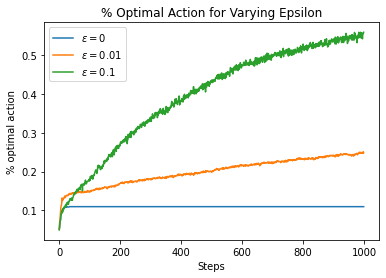

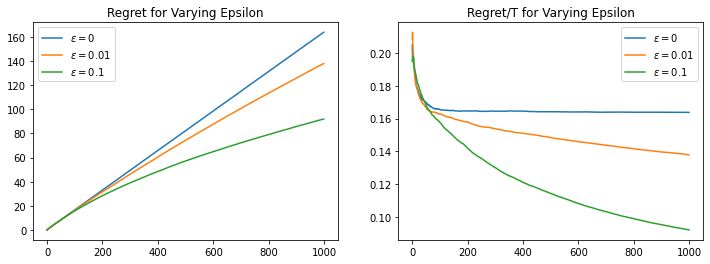

In [4]:
def question_2(runs=2000, time=1000):
    epsilons = [0, 0.01, 0.1]
    bandits = [Bandit(probabilities, epsilon=eps, sample_averages=True) for eps in epsilons]
    best_action_counts, rewards = simulate(runs, time, bandits)

    # percent optimal action
    optimal_action(best_action_counts, bandits, epsilon=True)
    
    # regret calculation
    regret_figure(rewards, bandits, epsilon=True)

question_2()

##### Question 2: Written Portion
From the computations and the graphs of Regret vs. Regret per round, we can see that the quantity $\frac{\rho}{t}$ does tend to 0 for the strategies we have used. Because the bandit requires time to learn the optimal strategy, regret in initial runs is much higher because more exploration occurs, and while exploring to determine the optimal solution, the bandit loses out on rewards because it is incapable of exploiting the optimal strategy. Once the bandit learns the optimal strategy, regret per round decreases and the overall regret starts to converge and grow slowly. 

##### Question 2: Extra Credit

100%|██████████| 2000/2000 [00:55<00:00, 35.90it/s]


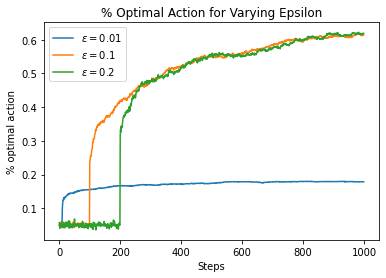

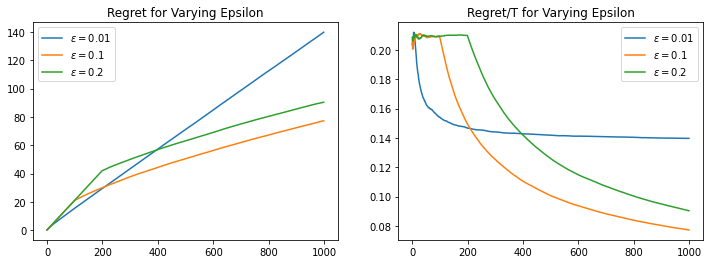

In [5]:
class extracredit_1:

    def __init__(self, p_click, T, k_arm = 20, epsilon = 0, initial = 0, step_size = 0.1):
    
        self.probabilities = p_click
        self.k = k_arm
        self.step_size = step_size
        self.indices = np.arange(self.k)
        self.time = 0
        self.T = T
        self.average_reward = 0
        self.epsilon = epsilon
        self.initial = initial

    def reset(self):
        self.q_true = self.probabilities
        self.q_estimation = np.zeros(self.k) + self.initial
        self.action_count = np.zeros(self.k)
        self.best_action = np.argmax(self.q_true)
        self.time = 0
    
    def act(self):
        if self.time < self.T * self.epsilon:
          return np.random.choice(self.indices)

        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    def step(self, action):
        reward = 0
        if np.random.rand() < self.probabilities[action]:
          reward = 1
        
        self.time += 1
        self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time
        self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
        
        return reward

def question_2a(runs=2000, time=1000):
    epsilons = [0.01, 0.1, 0.2]
    bandits = [extracredit_1(p_click=probabilities, T=time, epsilon=eps) for eps in epsilons]
    best_action_counts, rewards = simulate(runs, time, bandits)

    # percent optimal action
    optimal_action(best_action_counts, bandits, epsilon=True)
    
    # regret calculation
    regret_figure(rewards, bandits, epsilon=True)

question_2a()

100%|██████████| 2000/2000 [01:07<00:00, 29.57it/s]


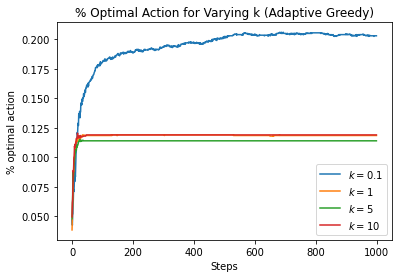

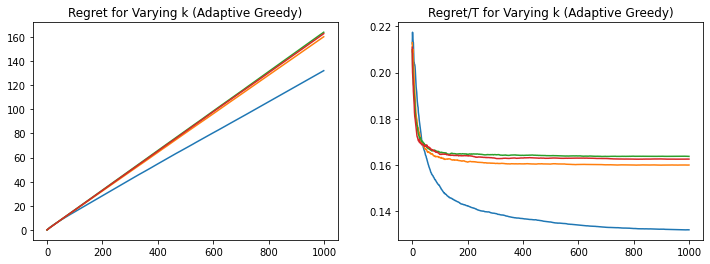

In [6]:
class extracredit_2:

    def __init__(self, p_click, T, exponent, k_arm = 20, epsilon = 0, initial = 0, step_size = 0.1):
    
        self.probabilities = p_click
        self.k = k_arm
        self.step_size = step_size
        self.indices = np.arange(self.k)
        self.time = 0
        self.T = T
        self.exponent = exponent
        self.average_reward = 0
        self.epsilon = epsilon
        self.initial = initial

    def reset(self):
        self.q_true = self.probabilities
        self.q_estimation = np.zeros(self.k) + self.initial
        self.action_count = np.zeros(self.k)
        self.best_action = np.argmax(self.q_true)
        self.time = 0
    
    def act(self):

        self.epsilon = np.exp(-1 * self.exponent * self.time)

        if np.random.rand() < self.epsilon:
          return np.random.choice(self.indices)

        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    def step(self, action):
        reward = 0
        if np.random.rand() < self.probabilities[action]:
          reward = 1
        
        self.time += 1
        self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time
        self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
        
        return reward

def question_2b(runs=2000, time=1000):
    exponents = [0.1, 1, 5, 10]
    bandits = [extracredit_2(p_click=probabilities, T=time, exponent=k) for k in exponents]
    best_action_counts, rewards = simulate(runs, time, bandits)

    # percent optimal action
    for i in range(len(bandits)):
        plt.plot(best_action_counts[i], label='$k = $' + str(bandits[i].exponent))
        plt.title("% Optimal Action for Varying k (Adaptive Greedy)")
    
    plt.xlabel('Steps')
    plt.ylabel('% optimal action')
    plt.legend()
    plt.show()
    
    # regret calculation
    regret = np.cumsum(rewards, axis=1)

    fig, axis = plt.subplots(1,2)
    fig.set_figwidth(fig.get_figwidth() * 2)

    for t in range(time):
        for i in range(len(regret)):
            regret[i,t] = (t+1) * bandits[i].probabilities[bandits[i].best_action] - regret[i,t]
            #regret[i,t] = (time) * bandits[i].probabilities[bandits[i].best_action] - regret[i,t]

    for i in range(len(bandits)):
      axis[0].plot(regret[i], label='$k = $' + str(bandits[i].exponent))
      axis[0].set_title("Regret for Varying k (Adaptive Greedy)")
    
    for i in range(len(regret)):
      for j in range(1, len(regret[0])):
        regret[i,j] /= (j+1)
    
    for i in range(len(bandits)):
      axis[1].plot(regret[i], label='$k = $' + str(bandits[i].exponent))
      axis[1].set_title("Regret/T for Varying k (Adaptive Greedy)")

question_2b()

#### Question 3: Repeat question 2, but use pure greedy ($\epsilon = 0$) with the optimistic initial values in {0, 0.5, 1, 5}. Also, try $\epsilon = 0.1$ and the optimistic initial value of 5. Only plot the percentage of times the optimal value was obtained, the regret, and regret per round curves.

100%|██████████| 2000/2000 [01:01<00:00, 32.77it/s]


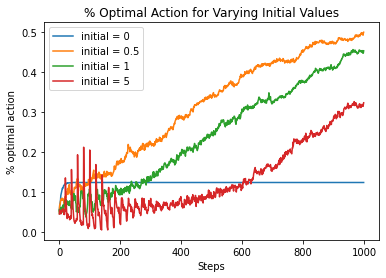

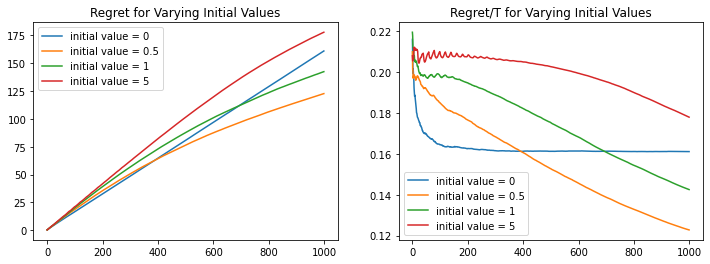

In [7]:
def question_3(runs=2000, time=1000):
    epsilon = 0
    initial_values = [0, 0.5, 1, 5]
    bandits = [Bandit(probabilities, epsilon=epsilon, initial=init) for init in initial_values]
    best_action_counts, rewards = simulate(runs, time, bandits)

    # percent optimal action
    optimal_action(best_action_counts, bandits, initial=True)
    
    # regret calculation
    regret_figure(rewards, bandits, initial=True)

question_3()

##### Question 3 Written
The initial value of 0.5 performed the best, as the regret and regret/T graphs converged faster for this initial value than the others. An initial value of 0 is too low and does not encourage enough exploration for the optimal solution to be found quickly, causing convergence to be slower. The optimal action may not be found in this case, in which case some suboptimal action is selected as optimal and regret/T converges extremely slowly or does not converge to 0. On the other hand, an initial value of 5 is too large and too optimistic, causing a much longer period of exploration and larger spikes during this period of exploration, because each arm has to be explored significantly before the reward estimaes converge to the actual reward. This causes a much slower convergence rate in Regret/T and more regret compared to the other initial values. The 0.5 initial value performed the best because it was able to strike a balance between exploration and exploitation that allowed the bandit to quickly determine the optimal action without excessive exploration and increasing regret.

#### Question 4: Repeat question 2, but use the UCB strategy with the parameter $c \in \{1, 2, 3\}$. Plot the percentage, regret, and regret per round curves.

100%|██████████| 2000/2000 [01:24<00:00, 23.72it/s]


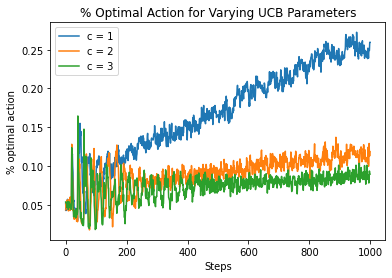

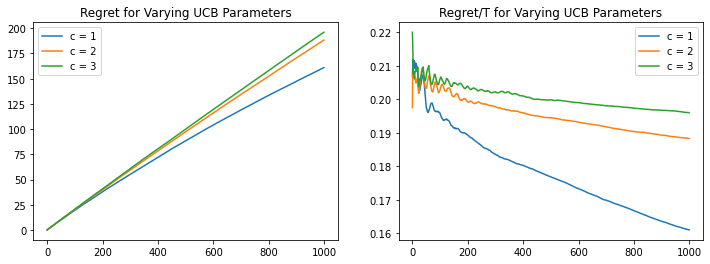

In [8]:
def question_4(runs=2000, time=1000):
    c = [1, 2, 3]

    bandits = [Bandit(probabilities, sample_averages=True, UCB_param = param) for param in c]
    best_action_counts, rewards = simulate(runs, time, bandits)

    # generate plots
    optimal_action(best_action_counts, bandits, ucb=True)
    regret_figure(rewards, bandits, ucb=True)
    
question_4()

##### Question 4 Written:
In the plots generated by Question 4, we can see the affect of the exploration parameter c that is used. For a larger value, c = 3, we can see that exploration is prioritized for longer compared to the other UCB parameters used. When c = 3, exploration occurs for longer (oscillation in the graph for % optimal action occurs for a longer period of time, and Regret/T takes longer to stabilize as well) causing convergence to be slower. Comparatively, when exploration is prioritized less (c = 1), convergence occurs faster whch can be seen in the regret graphs. 

Regardless of UCB parameter, we can see larger spikes at initial runs because during the initial runs, exploration is heavily prioritized and the bandit is testing out all 20 arms to see which arm yields the optimal reward, causing a lot of variance in the reward seen. 

#### Question 5: Repeat question 2, but use the gradient method over the softmax function. Use the learning rate $\alpha \in \{0.1, 0.4\}$ each with and without baseline; set true_reward = 0.1 for this method.

100%|██████████| 2000/2000 [01:27<00:00, 22.95it/s]


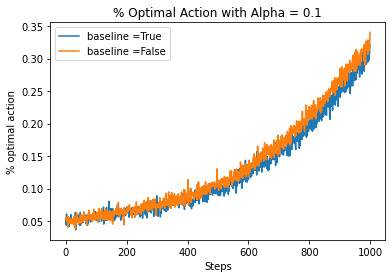

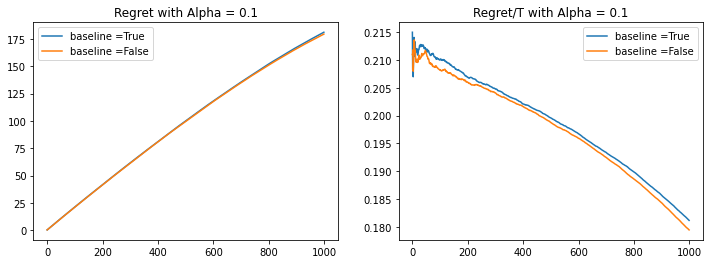

100%|██████████| 2000/2000 [01:30<00:00, 22.22it/s]


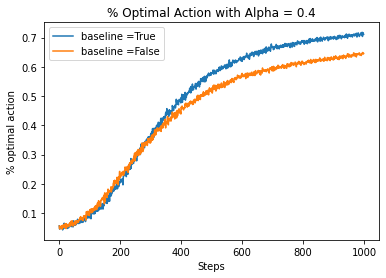

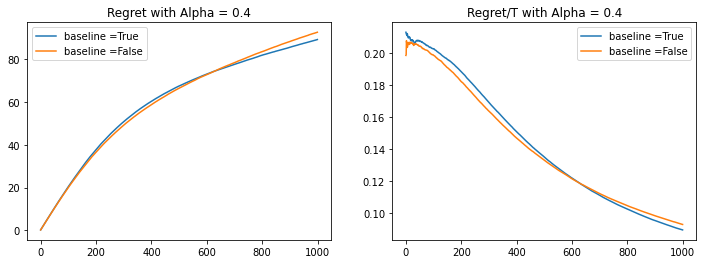

In [9]:
def question_5(runs=2000, time=1000):
    alpha = [0.1, 0.4]
    baseline = [True, False]
    true_reward = 0.1

    for a in alpha:

      bandits = [Bandit(probabilities, gradient = True, step_size = a, gradient_baseline = b, true_reward = true_reward) for b in baseline]
      best_action_counts, rewards = simulate(runs, time, bandits)

      optimal_action(best_action_counts, bandits, gradient=True)
      regret_figure(rewards, bandits, gradient=True)

question_5()